# **Natural Language Processing - Mini-Challenge 2: Sentiment Analysis**

For information about this mini-challenge, please view the document `NPR-Mini-Challenge-2-Sentiment-Analysis.pdf` in the `docs` directory.

## **1. Setup and Data Selection**

In [1]:
import os
import sys
import transformers
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join('../', 'src')))

from utils import *
from weak_labelling import *

transformers.logging.set_verbosity_error()

device = get_device()

/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MPS (Metal Performance Shaders)
Selected device: mps


### **Dataset Overview**
We utilize the [Stanford Sentiment Treebank (SST-2)](https://huggingface.co/datasets/stanfordnlp/sst2), a benchmark dataset for sentiment classification tasks. SST-2 consists of 11'855 single sentences extracted from movie reviews, parsed with the Stanford parser. These sentences are binary-labeled as either positive or negative, excluding neutral phrases. The dataset provides a comprehensive resource for evaluating sentiment classification models in natural language processing.

### **Practical Considerations**

In real-world scenarios, it is common to have a small amount of labeled data and a large pool of unlabeled data. To emulate this condition while effectively leveraging weak labeling techniques, we adopt the following approach:

- **Training Data**: A sample of 5'000 labeled data points is used for initial training. This limited dataset mimics a scenario where labeled data is scarce.

- **Weak Labeling Pool**: The remaining labeled data points (around 52'114 samples) are reserved to simulate an unlabeled pool for weak labeling. After applying weak labeling techniques, the top 5'000 high-confidence weak labels (for example, based on cosine similarity or other metrics) will be selected and added to the training data. This allows us to test if incorporating high-quality weak labels improves model performance.

- **Evaluation Data**: A separate dataset of 10'000 samples (df_eval_pool) is reserved for evaluation. The evaluation will be performed twice:

    - Without adding the weak-labeled data to the training set.
    
    - After adding the high-confidence weak-labeled data to the training set.

This setup ensures a clear separation of datasets for training and evaluation, allowing us to analyze the impact of weak labeling on model performance. By mimicking real-world constraints, this approach balances the need for practical experimentation with efficient use of available data.

In [2]:
# Load the training dataset
df_train = pd.read_csv("../data/train.csv")

# Reserve 10'000 samples for evaluation (to be kept separate from other splits)
df_train_remaining, df_eval_pool = train_test_split(
    df_train, test_size=10000, random_state=42, shuffle=True
)

# From the remaining data, sample 5'000 for training
df_train_sampled, df_weak_labeling_pool = train_test_split(
    df_train_remaining, test_size=(len(df_train_remaining) - 5000), random_state=42, shuffle=True
)

print(f"Dataset Sizes:")
print(f"Training (labeled): {len(df_train_sampled)} samples")
print(f"Weak Labeling Pool: {len(df_weak_labeling_pool)} samples")
print(f"Evaluation Pool: {len(df_eval_pool)} samples")

Dataset Sizes:
Training (labeled): 5000 samples
Weak Labeling Pool: 52349 samples
Evaluation Pool: 10000 samples


### **Hierarchical Nested Splits**
To analyze model performance variability and the effect of training data size, we create **hierarchical nested splits** from the sampled training data:

- **Split Sizes:** 10 training splits are created, each varying in size from 1% to 100% of the 5'000 sampled data (`[0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0]`).

- **Shuffling and Variability:** To reduce bias and assess performance variability, the entire training data is shuffled and 10 independent sets of nested splits are created. This enables robust analysis across different training configurations.


In [3]:
split_sizes = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0]
nested_splits_sets = create_nested_splits(df_train_sampled, split_sizes, num_sets=10)

Created Set 1 with nested splits.
Created Set 2 with nested splits.
Created Set 3 with nested splits.
Created Set 4 with nested splits.
Created Set 5 with nested splits.
Created Set 6 with nested splits.
Created Set 7 with nested splits.
Created Set 8 with nested splits.
Created Set 9 with nested splits.
Created Set 10 with nested splits.


For better organization and reproducibility, the hierarchical splits are saved in a structured folder format:

- **Base Folder**: ../data/nested_splits/

- **Subfolders**: Each set of splits is stored in its own subfolder (for example `set_1`, `set_2`, etc.).

- **Split Files**: Each split (for example 1%, 10%, etc.) within a set is saved as a CSV file (for example `split_1.csv`).

Now that we have loaded our data we can start creating our baseline model.

---

## **2. Baseline Model**

In this task, we utilize Fine-Tuning, where all layers of a pre-trained model (`bert-base-uncased`) are retrained to adapt to the sentiment classification task. This approach is suitable given the availability of hierarchical data splits ranging from 1% to 100% and the need to incorporate weak labels effectively. Fine-tuning enables us to fully leverage the model's pre-trained knowledge while tailoring it to our specific dataset.

### **Methodology**

1. **Model**:
    - We use BertForSequenceClassification for fine-tuning. The model's pre-trained transformer layers and the classification head are optimized for binary sentiment analysis.

2. **Data Splits**: 
    - Hierarchical nested splits ranging from 1% to 100% of the training data are created. 
    
    - Multiple sets of these splits are generated to test the variability in model performance across randomized subsets.

3. **Training**:
    - Tokenized input sentences are passed to the model.
    
    - Each split is trained individually to evaluate performance at different data sizes.

4. **Metrics**:
    - Metrics such as accuracy, precision, recall and F1-score are recorded for each split.
    
    - ariability in performance across different split sets is analyzed.

5. **Comparison**:
    - Performance is compared across data splits, with and without weak labels, to gain meaningful insights into the impact of labeled data size and weak labeling.

In [4]:
# Initialize Tokenizer and tokenize validation set
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Create validation dataset from reserved pool
validation_ds = tokenize_dataset(df_eval_pool, tokenizer)

In [5]:
# if variability_metrics.csv exists, load it and dont train model
if os.path.exists("../data/variability_metrics.csv"):
    df_metrics = pd.read_csv("../data/variability_metrics.csv")
    tqdm.write("Metrics loaded from file.")
else:
    tqdm.write("Metrics file not found. Training model...")

    metrics = []

    outer_pbar = tqdm(nested_splits_sets.items(), desc="Processing Sets", leave=True)
    for set_name, splits in outer_pbar:
        inner_pbar = tqdm(splits.items(), desc=f"Training Splits in {set_name}", leave=False)
        for size, train_df in inner_pbar:
            tqdm.write(f"Training with {size}% of data from {set_name}...")

            # Tokenize training data
            train_ds = tokenize_dataset(train_df, tokenizer)

            # Define a unique output directory for each split
            output_dir = f"./model_output/{set_name}_{size}"

            # Train the model and collect metrics
            split_metrics = train_and_evaluate(
                train_dataset=train_ds,
                eval_dataset=validation_ds,
                output_dir=output_dir,
                epochs=1,
                batch_size=8,
                learning_rate=2e-5,
                weight_decay=0.01
            )

            # Add split details to metrics
            split_metrics["split_size"] = size
            split_metrics["set_name"] = set_name
            metrics.append(split_metrics)

            tqdm.write(f"Completed training for {set_name} with {size}% data.")

        # After finishing a set, you can write a message if needed.
        tqdm.write(f"Finished processing splits in {set_name}.")

    df_metrics = pd.DataFrame(metrics)
    df_metrics.to_csv("../data/variability_metrics.csv", index=False)

    tqdm.write("All training runs completed and metrics saved.")

Metrics loaded from file.


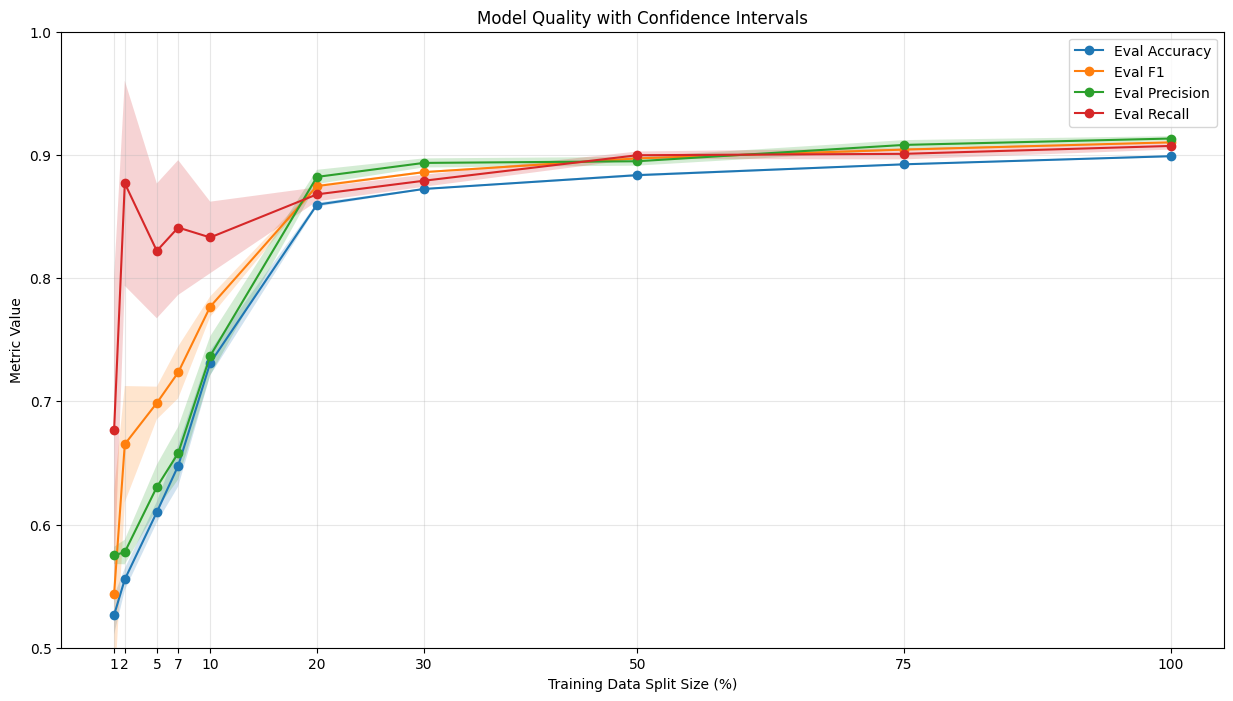

In [6]:
plot_metrics_with_confidence(
    df_metrics, 
    x_col="split_size", 
    y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"],
    title="Model Quality with Confidence Intervals"
)

#### **Observations from the Plot**

- When using small fractions of training data (1% - 10%), there is significant variability and lower metric values, especially in metrics like Accuracy and Precision. This variability is represented by the wide confidence intervals, indicating model instability.

- As more training data is used, metrics improve steadily. Confidence intervals start to shrink, suggesting greater stability in model performance.

- Beyond approximately 30% - 50% of training data, all metrics converge towards their maximum values and confidence intervals become almost negligible. This indicates the model benefits from larger datasets but saturates after a certain point.

- Recall appears to have higher variability in smaller training splits but stabilizes quickly with more data.

The graph effectively demonstrates the importance of data quantity for model performance and highlights diminishing returns as the data volume approaches the total available dataset.

### **Hyperparameter Tuning**

- **Learning Rate**: The learning rate is a critical hyperparameter that controls the step size during optimization. We experiment with different learning rates to find the optimal value that balances training speed and convergence.

- **Weight Decay**: Weight decay is a regularization term that penalizes large weights in the model. We tune this hyperparameter to prevent overfitting and improve generalization.

In [7]:
# if hyperparameter_tuning_results.csv exists, load it and dont train model
if os.path.exists("../data/hyperparameter_tuning_results.csv"):
    df_hyperparameters = pd.read_csv("../data/hyperparameter_tuning_results.csv")
    tqdm.write("Metrics loaded from file.")
else:
    tqdm.write("Metrics file not found. Training model...")

    # use random 100% split to train the model with different hyperparameters
    df_set_1_train = pd.read_csv("../data/nested_splits/set_1/split_100.csv")

    # Tokenize datasets
    train_ds = tokenize_dataset(df_set_1_train, tokenizer)
    eval_ds = tokenize_dataset(df_eval_pool, tokenizer)

    # Define hyperparameter values to test
    learning_rates = [4e-5, 5e-5]
    weight_decays = [0.0, 0.01, 0.05, 0.1]

    # Dictionary to store results
    results = []

    # Perform hyperparameter tuning
    for lr in learning_rates:
        for wd in weight_decays:
            output_dir = f"./model_output/lr_{lr}_wd_{wd}"
            print(f"Training with learning_rate={lr}, weight_decay={wd}")
            
            # Train and evaluate the model
            metrics = train_and_evaluate(
                train_dataset=train_ds,
                eval_dataset=eval_ds,
                output_dir=output_dir,
                epochs=1,
                batch_size=8,
                learning_rate=lr,
                weight_decay=wd
            )
            
            # Add hyperparameter details to metrics
            metrics['learning_rate'] = lr
            metrics['weight_decay'] = wd
            results.append(metrics)

    # Save the results to a CSV file for analysis
    df_hyperparameters = pd.DataFrame(results)
    df_hyperparameters.to_csv("../data/hyperparameter_tuning_results.csv", index=False)

    print("Hyperparameter tuning completed. Results saved to ../data/hyperparameter_tuning_results.csv.")

Metrics loaded from file.


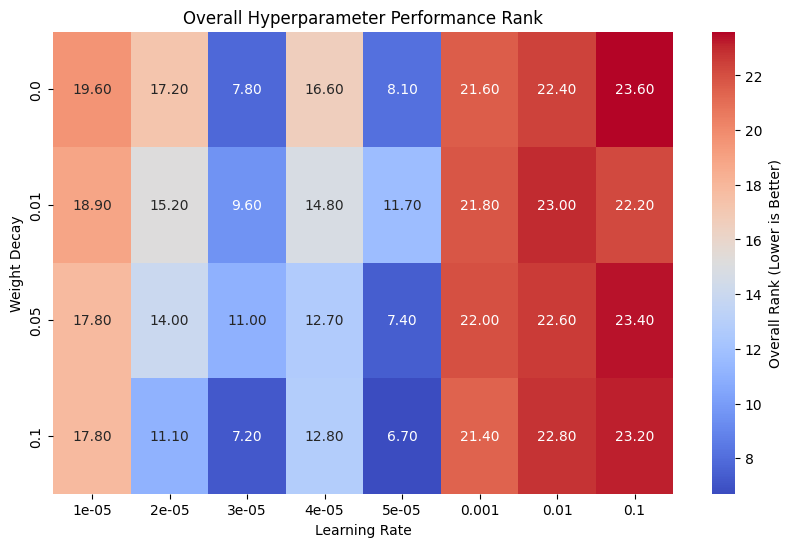

In [8]:
# Normalize and rank each metric
ranked_df = df_hyperparameters.copy()

# Reverse rankings for metrics where lower is better (e.g., eval_loss)
ranked_df["eval_loss_rank"] = ranked_df["eval_loss"].rank(ascending=True)
ranked_df["eval_accuracy_rank"] = ranked_df["eval_accuracy"].rank(ascending=False)
ranked_df["eval_precision_rank"] = ranked_df["eval_precision"].rank(ascending=False)
ranked_df["eval_recall_rank"] = ranked_df["eval_recall"].rank(ascending=False)
ranked_df["eval_f1_rank"] = ranked_df["eval_f1"].rank(ascending=False)

# Compute overall rank (average rank across all metrics)
ranked_df["overall_rank"] = ranked_df[
    ["eval_loss_rank", "eval_accuracy_rank", "eval_precision_rank", "eval_recall_rank", "eval_f1_rank"]
].mean(axis=1)

# Visualize the overall ranks in a heatmap
pivot_table = ranked_df.pivot(index="weight_decay", columns="learning_rate", values="overall_rank")
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_table, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={"label": "Overall Rank (Lower is Better)"}
)
plt.title("Overall Hyperparameter Performance Rank")
plt.xlabel("Learning Rate")
plt.ylabel("Weight Decay")
plt.show()


#### **Observations**
- Certain combinations of learning rate and weight decay achieve significantly better rankings, especially with moderately high weight decay and mid-range learning rates.
- Lower learning rates often result in better performance, but extremely low values may not always outperform slightly higher ones.
- Higher weight decay tends to complement certain learning rates, resulting in better rankings, while very low weight decay can underperform in some cases.
- Higher learning rates typically lead to a decline in performance, especially when combined with low weight decay.
- The heatmap suggests an interplay between learning rate and weight decay, with a noticeable sweet spot where the model achieves optimal performance.

---

## **2. Text Embeddings**

To represent texts numerically, we use **sentence embeddings** generated by the `all-MiniLM-L6-v2` model from the Sentence-Transformers library. These embeddings capture the semantic meaning of entire sentences as high-dimensional vectors, enabling us to quantify similarities between texts. By focusing on the validation and test sets, we ensure an unbiased evaluation of how well embeddings generalize to unseen data.

In [9]:
labeled_sentences = df_train_sampled["sentence"].tolist()
labeled_labels = df_train_sampled["label"].tolist()

# Generate embeddings with specifies model
model_name = "all-MiniLM-L6-v2"
embeddings = generate_embeddings(labeled_sentences, model_name, device)

# Dimension of embeddings
print(embeddings.shape)

Batches: 100%|██████████| 157/157 [00:05<00:00, 26.89it/s]

(5000, 384)


### **Are the embeddings standardized?**

If the mean is close to 0 and the standard deviation is close to 1, then the embeddings are standardized. Otherwise, they are not.

In [10]:
# Check mean and standard deviation for each dimension
mean_embeddings = np.mean(embeddings, axis=0)
std_embeddings = np.std(embeddings, axis=0)

print(f"Mean of embeddings across dimensions: {mean_embeddings.mean():.4f}")
print(f"Standard deviation of embeddings across dimensions: {std_embeddings.mean():.4f}")

Mean of embeddings across dimensions: 0.0003
Standard deviation of embeddings across dimensions: 0.0463


Based on these values, our embeddings are not standardized. We will keep this in mind when using the embeddings for downstream tasks.

### **Samples of most similar sentences**

To assess embedding quality, we calculate **cosine similarity**, which measures the semantic closeness between vectors. For example, we use a reference sentence and calculate its similarity with other sentences in the dataset. The top-5 most similar sentences are retrieved, showcasing the model's ability to group semantically related content.

This section helps us understand how well the embeddings capture sentence meaning and semantic relationships.

In [11]:
reference_index = 4
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: aims to be funny , uplifting and moving , sometimes all at once . 
Similarity: 0.6745, Sentence: uplifting , funny and wise . 
Similarity: 0.5296, Sentence: 's about individual moments of mood , and an aimlessness that 's actually sort of amazing . 
Similarity: 0.5120, Sentence: to be passionate and truthful 
Similarity: 0.5019, Sentence: to liven things up 


In [12]:
reference_index = 800
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: without any redeeming value whatsoever 
Similarity: 0.4189, Sentence: offers nothing 
Similarity: 0.4004, Sentence: worth 
Similarity: 0.3956, Sentence: with regret and , ultimately , finding redemption 
Similarity: 0.3584, Sentence: you value your time and money 


In [13]:
reference_index = 410
top_k_embeddings = get_and_print_most_similar_sentences(embeddings, labeled_sentences, reference_index)

Top-5 most similar sentences:
Similarity: 1.0000, Sentence: shrewd but pointless . 
Similarity: 0.5132, Sentence: a shrewd and effective film 
Similarity: 0.4497, Sentence: useless 
Similarity: 0.4238, Sentence: of pointless mayhem 
Similarity: 0.4165, Sentence: toothless 


In conclusion we can see that the most similar sentences to a reference sentence based on cosine similarity are indeed semantically related. This demonstrates the effectiveness of the sentence embeddings in capturing the underlying meaning of the text.

### **Furthest and Closest Sentences**

In [14]:
get_min_max_distance(embeddings, labeled_sentences)

Sentence with the furthest distance to any other sentence:
'a detailed historical document , '

Sentence closest to the most others (minimum average distance):
'it , offering fine acting moments and pungent insights '


### **Quantitative Exploration of Sentence Similarities**

To understand the quality of embeddings generated by our model, we perform a quantitative analysis by exploring the distribution of cosine similarities and pointwise distances within the same class (for example "Label 1" to "Label 1" and "Label 0" to "Label 0"). This helps assess how well the embeddings represent semantic similarities within each class.

#### **Analysis Steps**

1. **Cosine Similarities**:

   - Pairwise cosine similarities are computed for sentence embeddings within the same label group.

   - This quantifies the semantic similarity between embeddings, with values ranging from -1 (completely opposite) to 1 (identical).

2. **Pointwise Distances**:

   - Calculated as (1 - cosine similarity), the pointwise distance provides a dissimilarity measure between embeddings.

   - Lower distances indicate closer embeddings, reflecting better semantic cohesion.

3. **Density Plot**:

   - The KDE-plot visualizes the distribution of cosine similarities for each label, providing insights into class separability and cohesion.

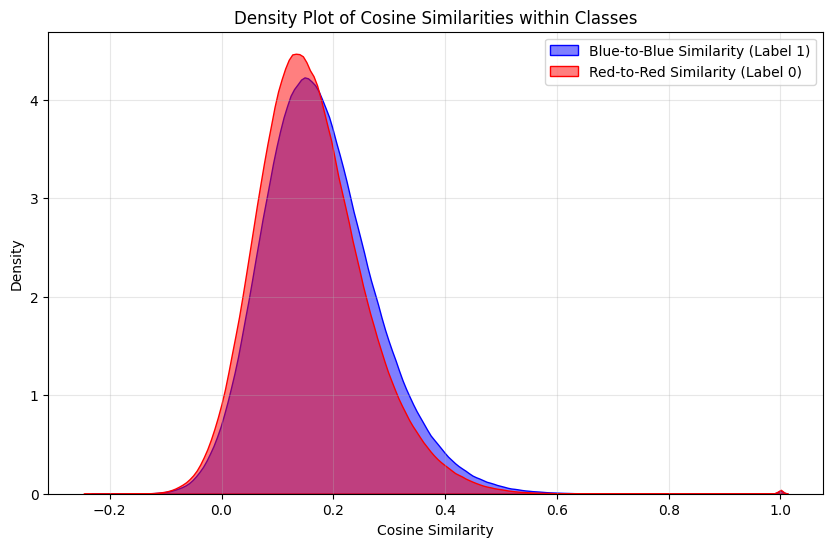

Blue-to-Blue Similarities:
Mean: 0.1763, Std: 0.1018

Red-to-Red Similarities:
Mean: 0.1604, Std: 0.0975

Blue-to-Blue Distances:
Mean: 0.8237, Std: 0.1018

Red-to-Red Distances:
Mean: 0.8396, Std: 0.0975


In [15]:
plot_similarity_density(embeddings, labeled_labels)

#### **Observations from the Plot**

- Similarities for "Label 1" (Blue-to-Blue) and "Label 0" (Red-to-Red) exhibit overlapping distributions, with slight differences in their peaks.

- Most similarities cluster in a moderate range, indicating that sentences within the same class generally exhibit semantic cohesion.

- The distributions suggest some overlap, but also indicate the presence of certain clusters where embeddings within a class are clearly more similar.

#### **Key Insights**

- **Within-Class Similarity**: Embeddings for both labels generally show moderate semantic similarity, reflecting that the model is capturing meaningful relationships between sentences within the same class.

- **Variability**: The distribution shapes and spreads suggest a degree of variability within each class, indicating that while some sentences are highly similar, others are more diverse.
  
- **Class Overlap**: The overlap between the two distributions implies that while the model can capture semantic patterns, there is room for improvement in enhancing class cohesion and separability.

### **Visualize Embeddings**

In this section we will examine the embeddings of the validation set using the dimensionality reduction techniques (t-SNE and UMAP) to visualize high-dimensional data in 2D space. These visualizations could help us understand the distribution of embeddings and identify clusters or patterns that may inform downstream tasks.

Reducing dimensionality with TSNE...


/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Reducing dimensionality with TSNE...


/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Reducing dimensionality with TSNE...


/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Reducing dimensionality with TSNE...


/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


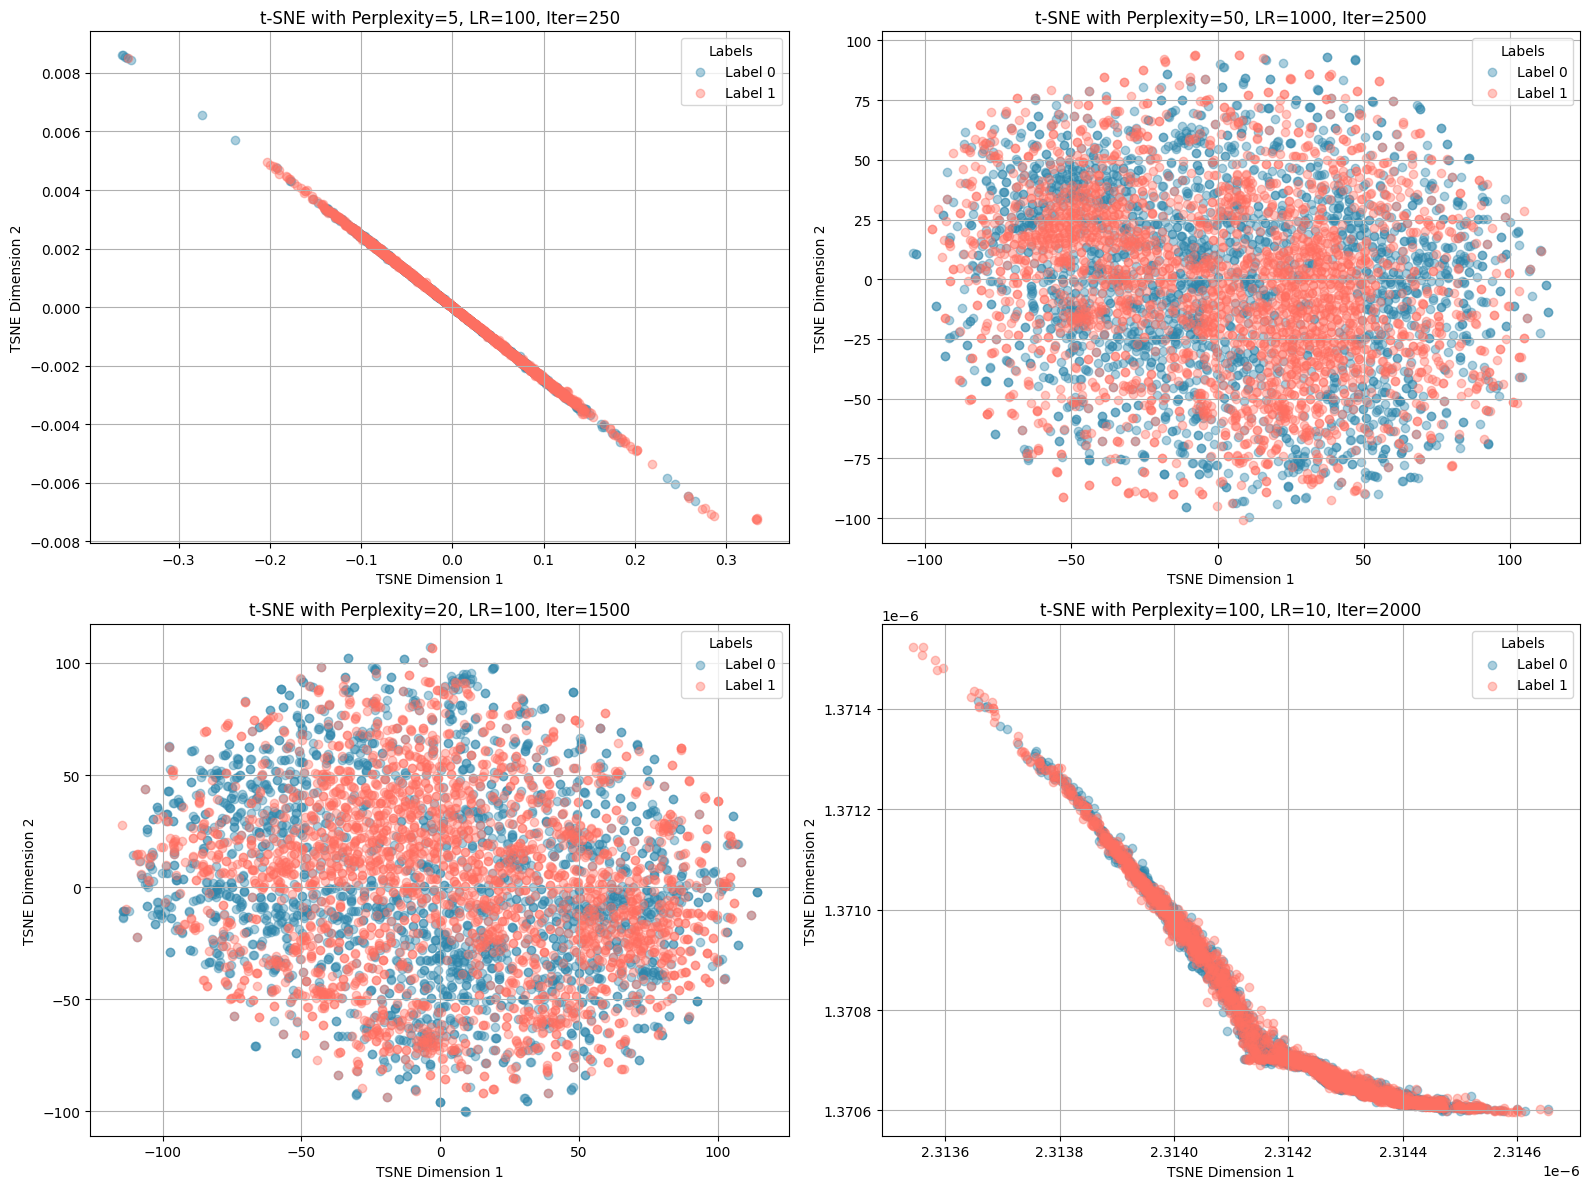

In [16]:
# Creating 2x2 subplots with different t-SNE hyperparameters
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define four different sets of hyperparameters for t-SNE with larger differences
tsne_params_list = [
    {'perplexity': 5, 'learning_rate': 100, 'n_iter': 250, 'early_exaggeration': 12},  # Low perplexity, low learning rate
    {'perplexity': 50, 'learning_rate': 1000, 'n_iter': 2500, 'early_exaggeration': 50},  # High perplexity, high learning rate, many iterations
    {'perplexity': 20, 'learning_rate': 100, 'n_iter': 1500, 'early_exaggeration': 10},  # Moderate perplexity, low learning rate
    {'perplexity': 100, 'learning_rate': 10, 'n_iter': 2000, 'early_exaggeration': 10}  # Very high perplexity, very low learning rate
]

titles = [
    "t-SNE with Perplexity=5, LR=100, Iter=250",
    "t-SNE with Perplexity=50, LR=1000, Iter=2500",
    "t-SNE with Perplexity=20, LR=100, Iter=1500",
    "t-SNE with Perplexity=100, LR=10, Iter=2000"
]

# Loop over the subplots and apply different parameters
for i, ax in enumerate(axes.flat):
    tsne_params = tsne_params_list[i]
    visualize_embeddings_with_params(
        embeddings,
        labels=labeled_labels, 
        title=titles[i],
        method="tsne",
        tsne_params=tsne_params,
        ax=ax
    )

plt.tight_layout()
plt.show()

#### **Observations from the t-SNE plots**

- The first plot shows a very compressed structure with points mostly aligned along a straight line. This indicates that the low Perplexity and Learning Rate parameters are causing t-SNE to focus too much on local structures, leading to an inadequate separation of data points.

- The second plot shows a much more spread-out distribution of points, indicating that increasing the Perplexity and Learning Rate creates more space for the data points. This configuration seems to capture the global structure of the data better and provides clearer distinctions between the clusters.

- In the third plot, the points are more evenly distributed, suggesting that the moderate Perplexity and Learning Rate values result in a balanced projection. The clusters appear well-separated without excessive stretching, providing a more informative visualization.

- The fourth plot shows a very tight clustering of points in a small area. This suggests that the high Perplexity combined with a low Learning Rate results in the data being overly compressed, which is likely due to the algorithm focusing on local distances too much and failing to reveal meaningful structure in the data.

The t-SNE embedding visualization demonstrates overlapping clusters for labels `0` and `1`, indicating that the embedding space does not perfectly separate the classes.

Reducing dimensionality with UMAP...


/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


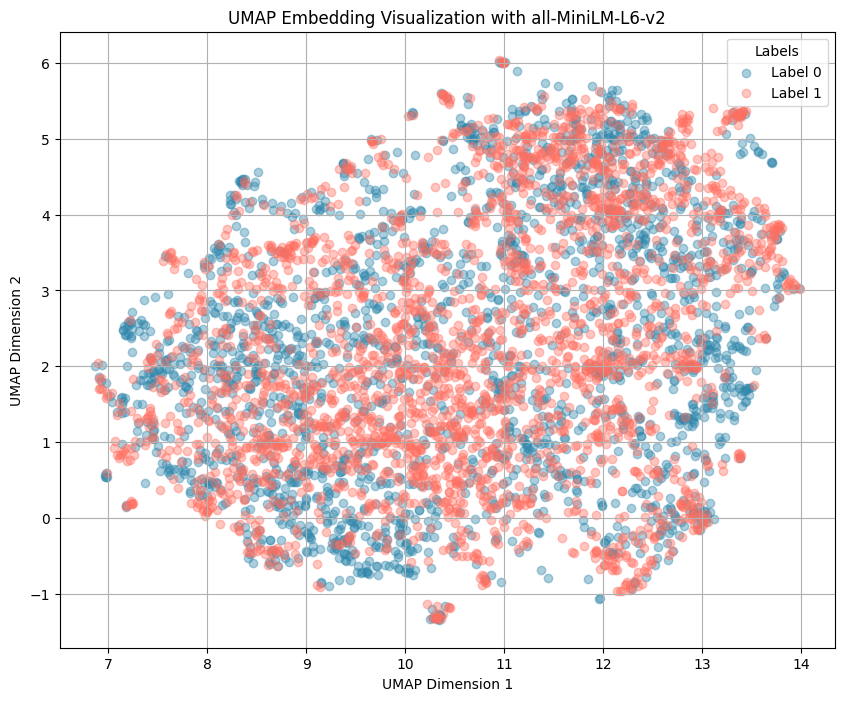

In [17]:
# Using UMAP
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"UMAP Embedding Visualization with {model_name}",
    method="umap"
)

The UMAP embedding visualization shows that the classes (`Label 0` and `Label 1`) are largely overlapping in the reduced 2D space, similar to the t-SNE method.

In conclusion, these overlaps could be due to the complexity of the sentiment classification task, or more probable the limitations and simplicity of the embedding model. Further steps could include changing the embedding model to achieve better separability.


### **Visualize Embeddings with Different Embedding Model**

Since the current embeddings do not perfectly separate the classes, we can try using a different embedding model. Based on the website [sbert.com](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html) we will use the `all-mpnet-base-v2` model to generate embeddings and visualize them using t-SNE and UMAP and see if the separability of classes improves.

In [18]:
model_name = "all-mpnet-base-v2"
embeddings = generate_embeddings(labeled_sentences, model_name, device)

# Dimension of embeddings
print(embeddings.shape)

Batches: 100%|██████████| 157/157 [00:18<00:00,  8.63it/s]

(5000, 768)


We can see that the `all-mpnet-base-v2` has a higher dimensionality than the previous model, which means that the embeddings will be more expressive and capture more information about the sentences. This could potentially lead to better separability of classes in the visualization.

Reducing dimensionality with TSNE...


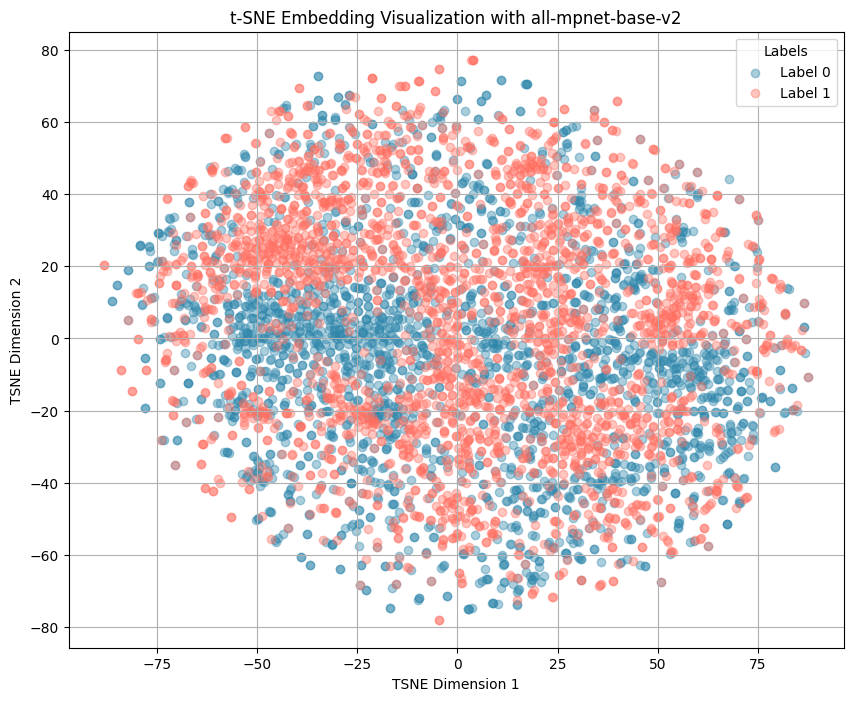

In [19]:
# Using t-SNE
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"t-SNE Embedding Visualization with {model_name}",
    method="tsne"
)

The t-SNE visualization using the `all-mpnet-base-v2` model shows better clustering compared to the previous model. We can clearly see some grouping patterns. However, there is still some overlap between the two classes, indicating challenges in complete separation of semantic representations for different labels.

Reducing dimensionality with UMAP...


/Users/nicko/.pyenv/versions/3.11.5/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


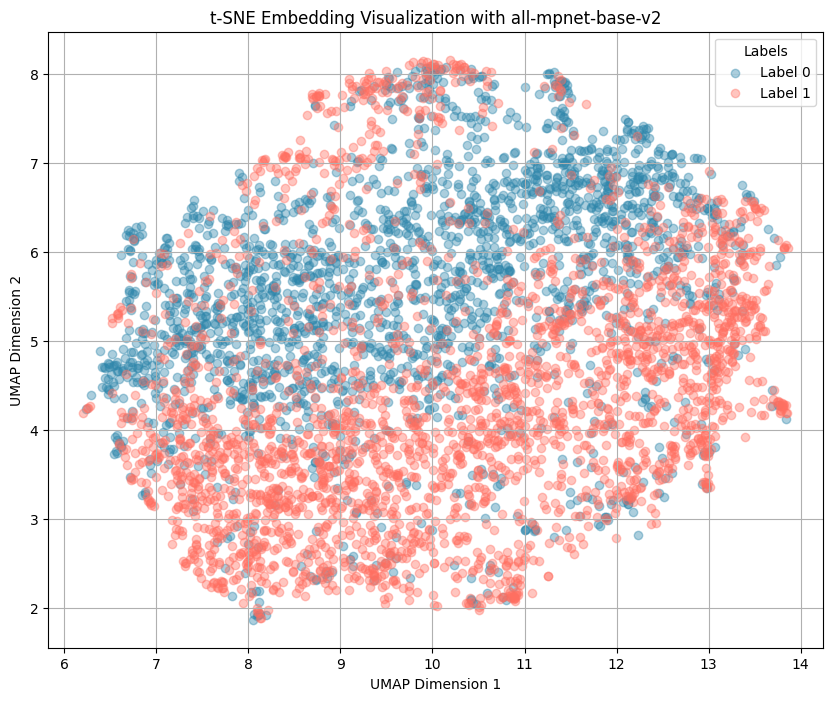

In [20]:
# Using UMAP
visualize_embeddings(
    embeddings,
    labels=labeled_labels,
    title=f"t-SNE Embedding Visualization with {model_name}",
    method="umap"
)

The UMAP embedding visualization shows similar results to the t-SNE method.

In conclusion, the `all-mpnet-base-v2` model provides better separability between classes compared to the previous model and we can consider using it for downstream tasks.

---

## **4. Weak Labeling**

Weak labeling assigns pseudo-labels to unlabeled data by leveraging embedding-based similarities and predefined techniques. The goal is to create meaningful labels for unlabeled datasets, enabling their use in downstream tasks such as training or evaluation.

- **Training and Validation Sets**: We split our initially labeled dataset into a training portion (used to generate reference embeddings and labels) and a validation portion (used solely for evaluation). Evaluating on this separate validation set ensures that our chosen weak labeling method generalizes beyond the data used to derive the embeddings.

- **Evaluation**: By comparing weak labels generated on the validation set (where we do have ground truth labels) against the true labels, we can assess each technique’s accuracy, precision, recall, and F1-score.

- **Test (Unlabeled) Set**: Once the best technique is identified, we apply it to the unlabeled test set. Since the test set lacks ground truth, we cannot directly measure performance. However, the weak labels derived allow us to potentially use this new data for model training or other downstream tasks.

#### **Techniques for Weak Labeling**

1. **Majority Vote**: Assigns the most frequent label among the top-k most similar labeled sentences (based on cosine similarity of embeddings).

2. **Weighted Voting**: Weights each of the top-k neighbor labels by their similarity score. The label with the highest cumulative weighted score is chosen as the weak label. This approach typically provides a finer-grained measure of neighborhood agreement and often outperforms simple majority voting.

3. **Centroid-Based Labeling**: Computes class centroids in the embedding space using the training set. Each unlabeled sample is assigned the label of the closest centroid. This provides a fast and scalable approach, though it may be less nuanced than neighbor-based methods.

#### **Comparison and Technique Selection**

We evaluate the three techniques on the validation set to determine the best performing method. After computing metrics such as accuracy, precision, recall, and F1-score, we select the approach that achieves the highest F1-score, as it balances precision and recall and is often most indicative of overall performance in classification tasks.

In [21]:
# Extract sentences and labels
all_sentences = df_weak_labeling_pool["sentence"].tolist()
all_labels = df_weak_labeling_pool["label"].tolist()

# Split into train and validation sets
sentences_train, sentences_validation, labels_train, labels_validation = train_test_split(
    all_sentences, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

labels_train = np.array(labels_train)
labels_validation = np.array(labels_validation)

# Generate embeddings for train and validation sets
embeddings_train = generate_embeddings(sentences_train, "all-mpnet-base-v2", device)
embeddings_validation = generate_embeddings(sentences_validation, "all-mpnet-base-v2", device)

# Evaluate and compare techniques on the validation set
results, techniques_predictions = evaluate_and_compare_techniques(
    embeddings_train,
    labels_train,
    labels_validation,
    embeddings_validation,
    k=5
)

# Print results
print("Comparison of Weak Labeling Techniques:")
for technique, metrics in results.items():
    print(f"\n{technique}:")
    for metric, value in metrics.items():
        print(f"{metric.capitalize()}: {value:.4f}")
    print("-"*15)

# Choose the best technique based on F1-score
best_technique = max(results, key=lambda t: results[t]['f1'])
print("\nBest technique chosen:", best_technique)

Batches: 100%|██████████| 328/328 [00:31<00:00, 10.26it/s]


Comparison of Weak Labeling Techniques:

Majority Vote:
Accuracy: 0.9022
Precision: 0.8973
Recall: 0.9309
F1: 0.9138
---------------

Weighted Vote:
Accuracy: 0.9036
Precision: 0.8989
Recall: 0.9317
F1: 0.9150
---------------

Centroid-Based:
Accuracy: 0.8731
Precision: 0.9018
Recall: 0.8664
F1: 0.8838
---------------

Best technique chosen: Weighted Vote


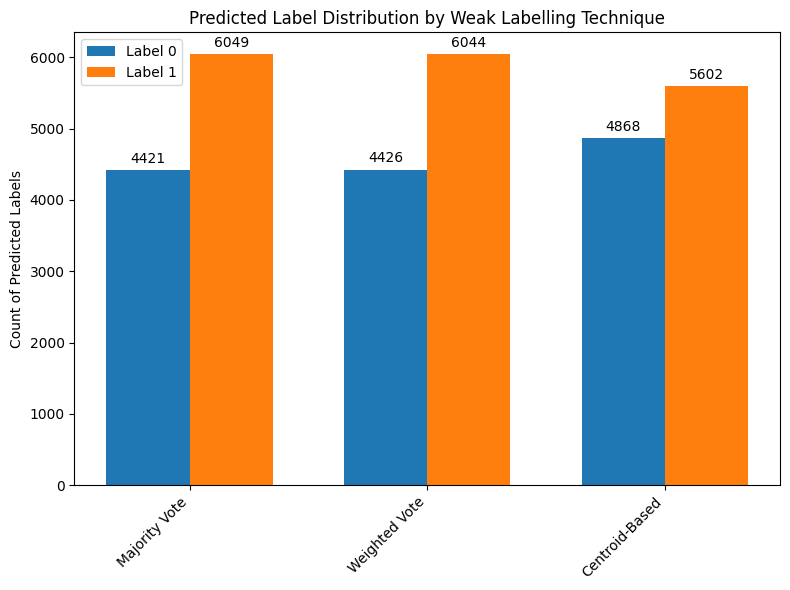

In [22]:
plot_predictions_distribution(techniques_predictions)

In the plot above we can see how each technique predicted the labels. Majority Vote and Weighted Vote are very similar, where Centroid-Based labelled more samples as `Label 0`.

### **Confidence-Based Selection for Data Augmentation**

Once the best technique is identified (in this case, Weighted Voting), we apply it to the unlabeled pool. However, rather than adding all weakly labeled data—some of which might be noisy—we select only the top 5'000 samples with the highest confidence scores. For Weighted Voting, this confidence is the margin between the chosen label’s cumulative weight and that of the runner-up label. High-confidence samples are more likely to be correctly labeled and thus can enhance the quality of the augmented training data.

By incorporating these top 5'000 confident weak labels into our original 5'000-sample training set, we end up with a 10'000-sample training set that can potentially improve the robustness and generalizability of our final model.

In [23]:
embeddings_train = generate_embeddings(df_train_sampled["sentence"].tolist(), "all-mpnet-base-v2", device)
embeddings_unlabeled = generate_embeddings(df_weak_labeling_pool["sentence"].tolist(), "all-mpnet-base-v2", device)

similarity_matrix_unlabeled = cosine_similarity(embeddings_unlabeled, embeddings_train)

# Get predicted weak labels and confidences
weak_labels, confidences = weighted_vote_with_confidence(similarity_matrix_unlabeled, labels_train, k=5)

# Add these to df_weak_labeling_pool as new columns
df_weak_labeling_pool['weak_label'] = weak_labels
df_weak_labeling_pool['confidence'] = confidences

# Sort by confidence
df_weak_labeling_pool_sorted = df_weak_labeling_pool.sort_values(by='confidence', ascending=False)

# Select top 5,000 most confident weakly labeled samples
top_5000 = df_weak_labeling_pool_sorted.head(5000).copy()

# Prepare these samples to be appended to df_train_sampled
# Make sure columns match your training data format. Suppose 'text' and 'label' are needed.
top_5000_for_training = top_5000[['sentence', 'weak_label']].rename(columns={'weak_label': 'label'})

# Concatenate with the original training set
df_train_augmented = pd.concat([df_train_sampled, top_5000_for_training], ignore_index=True)

print("Augmented training set size:", len(df_train_augmented))

Batches: 100%|██████████| 1636/1636 [02:42<00:00, 10.08it/s]


Augmented training set size: 10000


### **Sample of Weakly Labeled Sentences**

Here we will manually check a sample of weakly labeled sentences to assess the quality of the weak labeling technique. By examining the sentences and their assigned labels, we can maybe identify any potential issues or errors.

In [24]:
# Select 5 random samples
random_samples = df_train_augmented.sample(n=10, random_state=26)

# Display sentences and their corresponding weak labels
for index, row in random_samples.iterrows():
    print(f"Sentence: {row['sentence']}")
    print(f"Weak Label: {row['label']}")
    print("-" * 50)

Sentence: its leaden acting , dull exposition 
Weak Label: 1
--------------------------------------------------
Sentence: until it goes off the rails in its final 10 or 15 minutes 
Weak Label: 0
--------------------------------------------------
Sentence: a solid , psychological action film from hong kong . 
Weak Label: 1
--------------------------------------------------
Sentence: , it 's really unclear why this project was undertaken 
Weak Label: 0
--------------------------------------------------
Sentence: impresses as a skillfully assembled , highly polished and professional adaptation ... just about as chilling and unsettling as ` manhunter ' 
Weak Label: 1
--------------------------------------------------
Sentence: as a well-made evocation 
Weak Label: 1
--------------------------------------------------
Sentence: is not even as daring as john ritter 's glory days 
Weak Label: 0
--------------------------------------------------
Sentence: used the film as a bonus feature on the

Positive sentiments (Label: 1) are associated with praise or admiration, while negative sentiments (Label: 0) align with criticism or dismissive tones. 

The method appears to reasonably capture the polarity of sentiments based on contextual cues in the text, but is not perfect and may misclassify some sentences due to ambiguity or complexity.

---

## **5. Model training with additional weak labels**

We will extend the baseline training code to incorporate both hard labels (from the labeled data) and weak labels. This will involve:

1. Combining the hierarchically nested training splits with the weakly labeled data.
2. Training and evaluating the model for each split size.
3. Comparing the results to the baseline metrics.

In [25]:
split_sizes = [0.01, 0.02, 0.05, 0.075, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0]
nested_splits = create_nested_splits(df_train_augmented, split_sizes, num_sets=1, base_folder="../data/nested_splits_augmented")

Created Set 1 with nested splits.


In [26]:
# if hyperparameter_tuning_results.csv exists, load it and dont train model
if os.path.exists("../data/weak_label_metrics.csv"):
    df_weak_metrics = pd.read_csv("../data/weak_label_metrics.csv")
    tqdm.write("Metrics loaded from file.")
else:
    tqdm.write("Metrics file not found. Training model...")

    metrics_weak = []

    outer_pbar = tqdm(nested_splits.items(), desc="Processing Sets", leave=True)
    for set_name, splits in outer_pbar:
        inner_pbar = tqdm(splits.items(), desc=f"Training Splits in {set_name}", leave=False)
        for size, df_train in inner_pbar:
            print(f"Training with {size} of augmented data...")
            
            # Tokenize combined training set
            train_ds = tokenize_dataset(df_train, tokenizer)

            output_dir = f"./model_output/augmented_{size}"

            # Train the model and collect metrics
            split_metrics = train_and_evaluate(
                train_dataset=train_ds,
                eval_dataset=validation_ds,
                output_dir=output_dir,
                epochs=1,
                batch_size=8,
                learning_rate=5e-5,
                weight_decay=0.1
            )

            split_metrics["split_size"] = size
            metrics_weak.append(split_metrics)

            tqdm.write(f"Completed training with {size}% data.")

    # Convert metrics to DataFrame
    df_weak_metrics = pd.DataFrame(metrics_weak)
    df_weak_metrics.to_csv("../data/weak_label_metrics.csv", index=False)

Metrics loaded from file.


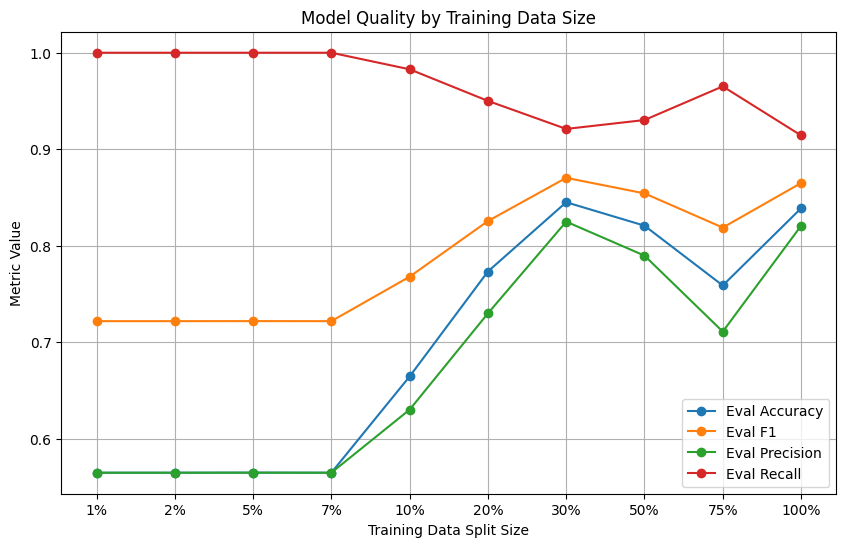

In [27]:
plot_metrics(df_weak_metrics, x_col="split_size", y_cols=["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"])

When the training set is extremely small (1–5%), the model likely defaults to predicting a single class, causing all metrics to appear fixed and uninformative. As the training size grows (above ~7%), the model begins to learn meaningful patterns, leading to diverging and improving metrics. In other words, early stagnation of metrics indicates no real learning; once enough data is provided, the model’s performance metrics start to reflect true predictive capability. At around 30% of the training data, the model reaches good performance.

---

## **6. Model comparison**

This section compares the baseline model performance with the model trained on weakly labeled data. We also evaluate the weak labels directly to determine if they are sufficient for sentiment classification or if training a classification model using these labels is more effective.

1. Compare Baseline and Weak Label Models
2. Evaluate Weak Labels Directly
3. Decide on the Best Approach

In [28]:
# Load metrics
baseline_metrics = pd.read_csv("../data/variability_metrics.csv")
weak_label_metrics = pd.read_csv("../data/weak_label_metrics.csv")

# Convert "split_size" to numeric
baseline_metrics["split_size"] = baseline_metrics["split_size"].str.replace('%', '').astype(float)
weak_label_metrics["split_size"] = weak_label_metrics["split_size"].str.replace('%', '').astype(float)

# Ensure only numeric columns are grouped and calculated
numeric_cols_baseline = [col for col in baseline_metrics.columns if col != "split_size" and pd.api.types.is_numeric_dtype(baseline_metrics[col])]
numeric_cols_weak = [col for col in weak_label_metrics.columns if col != "split_size" and pd.api.types.is_numeric_dtype(weak_label_metrics[col])]

# Group by split size and calculate mean for numeric columns
baseline_metrics_grouped = baseline_metrics.groupby("split_size")[numeric_cols_baseline].mean()
weak_label_metrics_grouped = weak_label_metrics.groupby("split_size")[numeric_cols_weak].mean()

# Reset index to make split_size a column (only if not already present)
baseline_metrics_grouped = baseline_metrics_grouped.reset_index()
weak_label_metrics_grouped = weak_label_metrics_grouped.reset_index()

# Sort by split size
baseline_metrics_grouped = baseline_metrics_grouped.sort_values(by="split_size")
weak_label_metrics_grouped = weak_label_metrics_grouped.sort_values(by="split_size")

# Extract xticks for plotting
xticks = sorted(baseline_metrics_grouped["split_size"].unique())

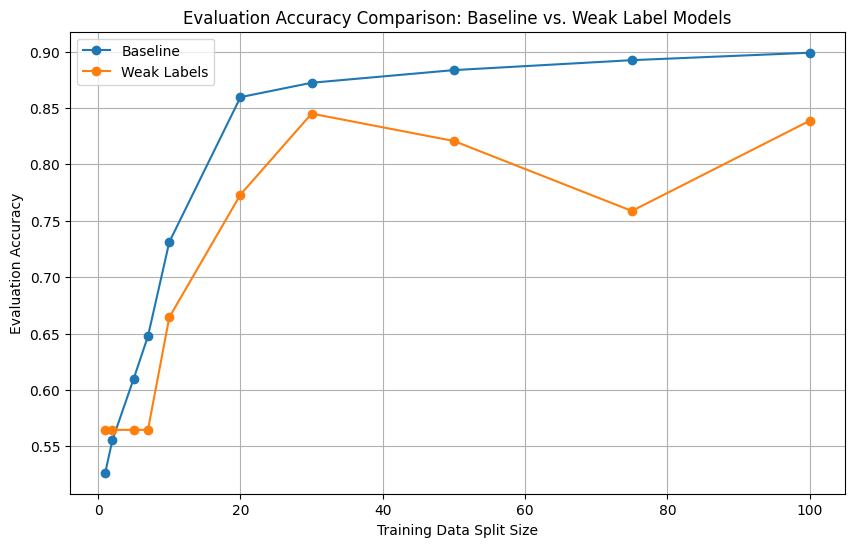

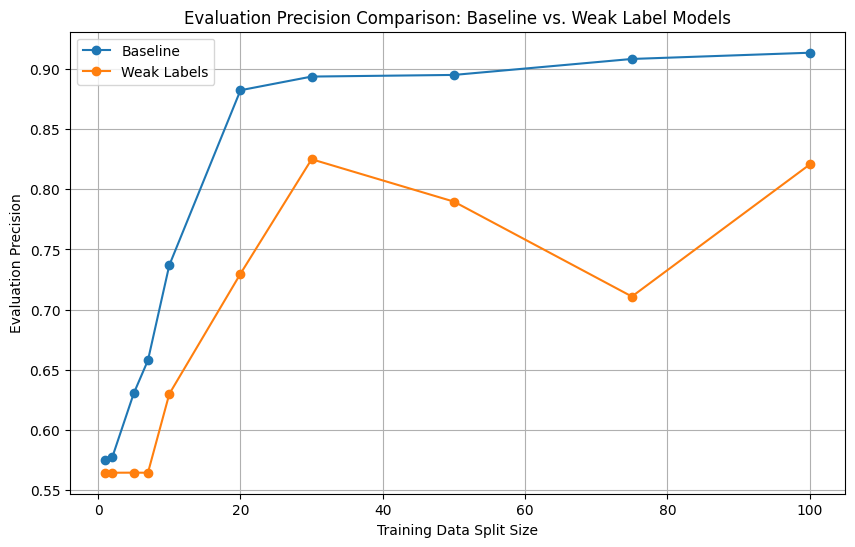

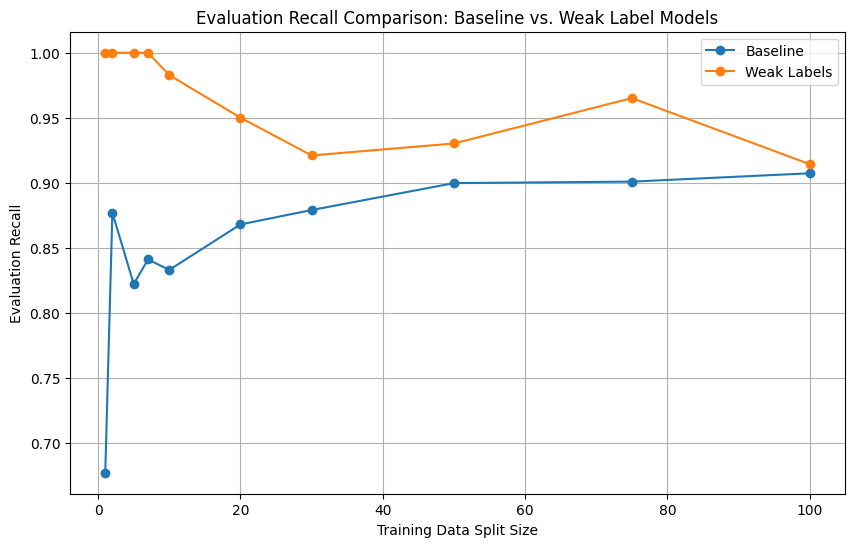

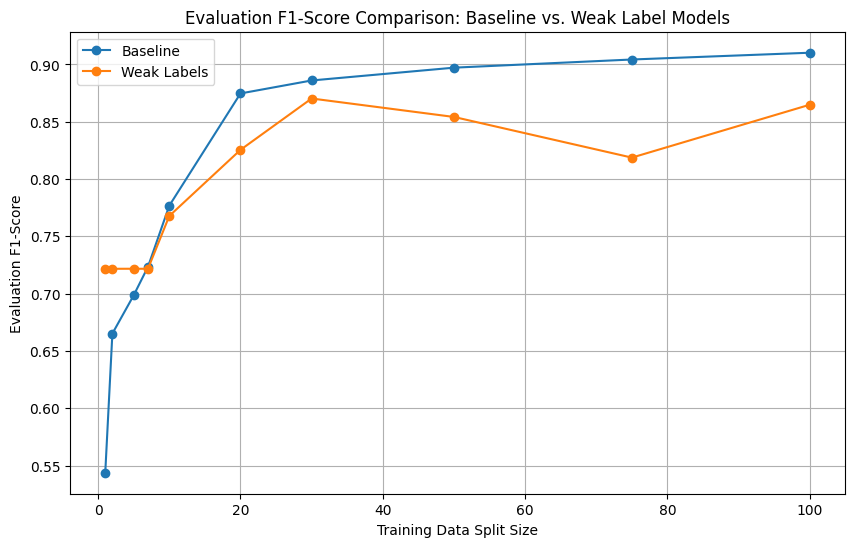

In [29]:
# Plotting function for comparison
def plot_model_comparison(baseline_df, weak_label_df, metric, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(baseline_df["split_size"], baseline_df[metric], label="Baseline", marker="o")
    plt.plot(weak_label_df["split_size"], weak_label_df[metric], label="Weak Labels", marker="o")
    plt.title(f"{ylabel} Comparison: Baseline vs. Weak Label Models")
    plt.xlabel("Training Data Split Size")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot metrics
metrics_to_plot = {
    "eval_accuracy": "Evaluation Accuracy",
    "eval_precision": "Evaluation Precision",
    "eval_recall": "Evaluation Recall",
    "eval_f1": "Evaluation F1-Score",
}

for metric, ylabel in metrics_to_plot.items():
    plot_model_comparison(baseline_metrics_grouped, weak_label_metrics, metric, ylabel)

### Decide on the Best Approach

**Observations:**

- Baseline vs. Weak Label Model:

    - The baseline model mostly outperforms the weak label model, especially at larger data split sizes (>10%), with improvements in accuracy and F1 scores.

    - At smaller splits, the weak label model is better. However, we spoke about that the model could be defaulting to a single class at small splits.

**Conclusion:**

Training a classification model with weak labels does not seem worthwhile as it does not improve performance over the baseline model. While weak labels offer a cost-effective alternative to manual annotation and deliver okay results, they fail to boost the classification model's performance sufficiently. Therefore, **no time savings factor** was calculated, as the weak labeling approach did not achieve the expected improvements in model performance.

### General Conclusion

This study highlights the challenges and potential of integrating weak labeling into a classification workflow. While the baseline model slightly outperformed the weak label model in most cases, the difference in performance was not substantial. This suggests that, under different circumstances (such as improved weak label generation strategies or larger datasets) the use of weak labels might provide significant advantages. Weak labeling remains a promising approach for reducing manual annotation efforts and could be particularly beneficial when dealing with limited hard labels or resource constraints. Further exploration of more robust weak labeling techniques and their application to diverse datasets could unlock their full potential in enhancing classification performance.

---

## **Use of AI**

In this project, ChatGPT was used extensively to support the implementation and documentation of the sentiment analysis pipeline. The following tasks were accomplished using the tool:

1. **Code Implementation**:
   - Developing weak labeling strategies (majority vote, weighted vote, centroid-based).
   - Calculating cosine similarities between embeddings and selecting samples with high similarity scores.
   - Designing a training loop and integrating weak labels into the model pipeline.

2. **Optimization and Debugging**:
   - Refining code to ensure dataset consistency and compatibility with project requirements.
   - Streamlining processes to maintain a balanced training set size of 10,000 samples.

3. **Documentation**:
   - Adding detailed comments to complex code sections to enhance readability and reproducibility.


### Assessment of Prompting Strategies

#### Prompting Strategies Used

1. **Task-Specific Prompts**:
   - Example: "Generate code to calculate cosine similarity and select the top-k most similar samples."
   - Effectiveness: Delivered targeted, actionable code snippets with minimal modifications.

2. **Iterative Refinement**:
   - Example: Initial prompts provided a general framework, followed by refinements to address specific requirements or edge cases.
   - Effectiveness: Allowed for precise tailoring of solutions to meet project goals.

#### Most Successful Strategy

- **Task-Specific Prompts**:
  - **Contribution to Solving the Task**: Enabled efficient development of specific functionalities, such as cosine similarity calculations and dataset augmentation.
  - **Contribution to Skill Acquisition**: Reinforced understanding of key techniques, including text embedding and weak labeling.

### Reflection on AI Tool Usage

The use of ChatGPT significantly accelerated the development process, especially for repetitive or complex tasks. By leveraging AI, we could focus more on strategic decisions and evaluation, while routine coding tasks were handled efficiently. Moreover, the iterative refinement process fostered a deeper understanding of key concepts in weak labeling and sentiment analysis.

The dual role of ChatGPT as both a problem-solving assistant and a learning tool proved invaluable, contributing to the success of this project and the acquisition of advanced skills in natural language processing.